# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd
import random

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'gender-recognizer'

train_emotion_dir = EMOTION_FILE_PATH / 'images/train'
test_emotion_dir = EMOTION_FILE_PATH / 'images/validation'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/gender-recognizer'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/gender-recognizer
There are 2 directories and 0 images in /kaggle/input/gender-recognizer/dataset
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/MEN
There are 1 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN/MEN


## 2. Data Exploration and Preprocessing

In [9]:
def convert_to_df(data_path):
    paths = [path for path in data_path.rglob('*/*') if path.suffix.lower() in ['.jpg', '.png']]

    # Create the DataFrame with relevant columns
    df = pd.DataFrame({
        'file_path': paths,
        'file_name': [path.name for path in paths],  # Extract file name
        'label': [path.parts[-2] for path in paths]  # Extract folder name as label
    })
    return df

In [10]:
# Age Dataset
age_df = convert_to_df(AGE_FILE_PATH)
print(age_df.head())

# Gender Dataset
gender_df = convert_to_df(GENDER_FILE_PATH)
print(gender_df.head())

                                        file_path file_name label
0  /kaggle/input/facial-age/face_age/057/6802.png  6802.png   057
1  /kaggle/input/facial-age/face_age/057/3702.png  3702.png   057
2  /kaggle/input/facial-age/face_age/057/8810.png  8810.png   057
3  /kaggle/input/facial-age/face_age/057/6759.png  6759.png   057
4  /kaggle/input/facial-age/face_age/057/1846.png  1846.png   057
                                           file_path            file_name  \
0  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_112131.jpg   
1  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_133142.jpg   
2  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160304.jpg   
3  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240609_200332.jpg   
4  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160729.jpg   

  label  
0   MEN  
1   MEN  
2   MEN  
3   MEN  
4   MEN  


In [11]:
age_df.shape, gender_df.shape

((19556, 3), (1937, 3))

In [12]:
# Droping duplicated values in age dataset
print(age_df.duplicated(['file_name', 'label']).sum())
age_df.drop_duplicates(['file_name', 'label'], inplace=True)

# Droping duplicated values in gender dataset
print(gender_df.duplicated(['file_name', 'label']).sum())
gender_df.drop_duplicates(['file_name', 'label'], inplace=True)

9778
646


In [13]:
age_df.shape, gender_df.shape

((9778, 3), (1291, 3))

In [14]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['label'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}


,file_path,file_name,label,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [15]:
gender_df['label'].str.lower()
gender_df.head()

,file_path,file_name,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_112131.jpg,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_133142.jpg,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160304.jpg,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_200332.jpg,MEN
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160729.jpg,MEN


In [16]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

print(gender_df.isnull().sum())
gender_df.dropna(inplace=True)

file_path         0
file_name         0
label             0
age_category    794
dtype: int64
file_path    0
file_name    0
label        0
dtype: int64


In [17]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [18]:
age_df.drop('label', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [19]:
train_age_data, test_age_data = train_test_split(age_df, shuffle=True, test_size=0.2)
print(train_age_data.head())

train_gender_data, test_gender_data = train_test_split(gender_df, shuffle=True, test_size=0.2)
train_gender_data.head()

                                           file_path file_name age_category
5540  /kaggle/input/facial-age/face_age/008/4920.png  4920.png        Child
119   /kaggle/input/facial-age/face_age/061/2925.png  2925.png      Elderly
8739  /kaggle/input/facial-age/face_age/005/5998.png  5998.png        Child
3170  /kaggle/input/facial-age/face_age/027/4599.png  4599.png  Young Adult
6937  /kaggle/input/facial-age/face_age/021/9606.png  9606.png  Young Adult


,file_path,file_name,label
459,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_194332.jpg,MEN
894,/kaggle/input/gender-recognizer/dataset/WOMAN/...,tengrai_image_1718701584_7767704.png,WOMAN
76,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_203519.jpg,MEN
49,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_201324.jpg,MEN
630,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_114405.jpg,MEN


In [20]:
train_age_data.shape, test_age_data.shape

((7187, 3), (1797, 3))

In [21]:
train_gender_data.shape, test_gender_data.shape

((1032, 3), (259, 3))

## 3. Data Transformation for All Dataset

In [22]:
# Define the transformation pipeline
train_transforms_trivial = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply TrivialAugmentWide
    transforms.ToTensor()  # Convert to tensor
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.ToTensor()  # Convert to tensor
])

## 4. Creating PyTorch Datasets

### 4.1 Creating Custom Dataset for Age and Gender Data

In [23]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, file_paths, categories, idx, transform=None):
        """
        Args:
            file_paths (list): List of image file paths.
            categories (list): List of all categories corresponding to the images.
            idx (dict): Mapping of all categories to numerical indices.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.file_paths = list(file_paths)
        self.categories = list(categories)
        self.idx = idx
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Retrieve image path and age category
        img_path = self.file_paths[idx]
        category = self.categories[idx]

        # Map the age category to its corresponding index
        label_idx = self.idx[category]

        # Load the image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label_idx

In [24]:
gender_labels = list(train_gender_data['label'].unique())
gender_idx = {label:i for i, label in enumerate(gender_labels)}

gender_idx

{'MEN': 0, 'WOMAN': 1}

In [25]:
# Initialize the datasets for Age Dataset
age_train_dataset = CustomDataset(
    file_paths=train_age_data['file_path'].tolist(),
    categories=train_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=train_transforms_trivial
)

age_test_dataset = CustomDataset(
    file_paths=test_age_data['file_path'].tolist(),
    categories=test_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=test_transforms
)

# Initialize the datasets for Gender Dataset
gender_train_dataset = CustomDataset(
    file_paths=train_gender_data['file_path'].tolist(),
    categories=train_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=train_transforms_trivial
)

gender_test_dataset = CustomDataset(
    file_paths=test_gender_data['file_path'].tolist(),
    categories=test_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=test_transforms
)

In [26]:
# Test the training dataset
img, label_idx = age_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 1


In [27]:
# Test the training dataset
img, label_idx = gender_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 0


In [28]:
age_train_dataset[3]

(tensor([[[0.1216, 0.1216, 0.1216,  ..., 0.8745, 0.8667, 0.8549],
          [0.1216, 0.1216, 0.1216,  ..., 0.8745, 0.8667, 0.8510],
          [0.1216, 0.1216, 0.1216,  ..., 0.8784, 0.8667, 0.8549],
          ...,
          [0.1608, 0.1608, 0.1647,  ..., 0.2627, 0.2627, 0.2549],
          [0.1608, 0.1608, 0.1647,  ..., 0.2667, 0.2588, 0.2392],
          [0.1608, 0.1608, 0.1647,  ..., 0.2706, 0.2627, 0.2392]],
 
         [[0.0824, 0.0824, 0.0824,  ..., 0.9294, 0.9333, 0.9255],
          [0.0824, 0.0824, 0.0824,  ..., 0.9176, 0.9216, 0.9137],
          [0.0824, 0.0824, 0.0824,  ..., 0.9137, 0.9098, 0.9059],
          ...,
          [0.1059, 0.1059, 0.1098,  ..., 0.5608, 0.5608, 0.5569],
          [0.1059, 0.1059, 0.1098,  ..., 0.5686, 0.5608, 0.5451],
          [0.1059, 0.1059, 0.1098,  ..., 0.5765, 0.5686, 0.5451]],
 
         [[0.0431, 0.0431, 0.0431,  ..., 0.7686, 0.7686, 0.7686],
          [0.0431, 0.0431, 0.0431,  ..., 0.7647, 0.7686, 0.7608],
          [0.0431, 0.0431, 0.0431,  ...,

In [29]:
gender_train_dataset[3]

(tensor([[[0.1373, 0.1373, 0.1412,  ..., 0.2157, 0.2118, 0.2118],
          [0.1373, 0.1412, 0.1412,  ..., 0.2118, 0.2078, 0.2078],
          [0.1412, 0.1412, 0.1412,  ..., 0.2078, 0.2039, 0.2039],
          ...,
          [0.1098, 0.1059, 0.0980,  ..., 0.2510, 0.2980, 0.2745],
          [0.1098, 0.1098, 0.1020,  ..., 0.2667, 0.2941, 0.2510],
          [0.1098, 0.1137, 0.1098,  ..., 0.2745, 0.2863, 0.2471]],
 
         [[0.1451, 0.1451, 0.1451,  ..., 0.2078, 0.2039, 0.2039],
          [0.1451, 0.1451, 0.1451,  ..., 0.2078, 0.2039, 0.2039],
          [0.1451, 0.1451, 0.1451,  ..., 0.2078, 0.2078, 0.2078],
          ...,
          [0.1333, 0.1294, 0.1216,  ..., 0.2549, 0.2941, 0.2706],
          [0.1333, 0.1333, 0.1294,  ..., 0.2667, 0.2863, 0.2510],
          [0.1294, 0.1333, 0.1333,  ..., 0.2706, 0.2784, 0.2471]],
 
         [[0.1765, 0.1765, 0.1804,  ..., 0.1922, 0.1882, 0.1882],
          [0.1765, 0.1804, 0.1804,  ..., 0.1922, 0.1882, 0.1882],
          [0.1804, 0.1804, 0.1804,  ...,

In [30]:
age_train_dataset.idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}

In [31]:
gender_train_dataset.idx

{'MEN': 0, 'WOMAN': 1}

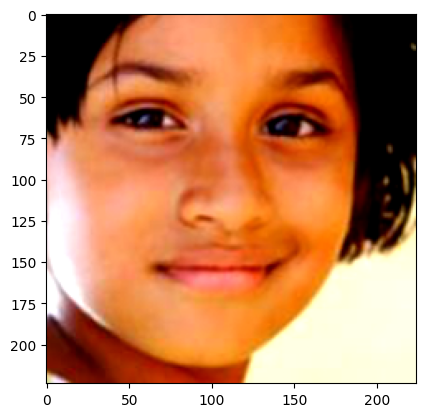

In [32]:
plt.imshow(age_train_dataset[0][0].permute(1, 2, 0))

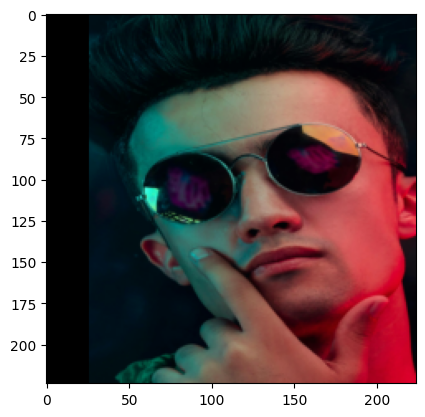

In [33]:
plt.imshow(gender_train_dataset[0][0].permute(1, 2, 0))

In [34]:
import matplotlib.pyplot as plt

# Adjusted display_random_images function
def display_random_images(dataset, classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
        print("n should NOT be larger than 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_samples_idx):
        img_tensor, label = dataset[idx]
        
        # Convert the tensor to numpy for matplotlib
        img_np = img_tensor.permute(1, 2, 0).numpy()
        
        # Scale pixel values back to [0, 255] for display
        img_np = img_np * 255  # If normalized to [0, 1]
        img_np = img_np.astype("uint8")  # Convert to integers for display

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        
        title = f"Class: {classes[label]}" if classes else f"Label: {label}"
        if display_shape:
            title += f"\nShape: {img_tensor.shape}"
        plt.title(title)

    plt.show()

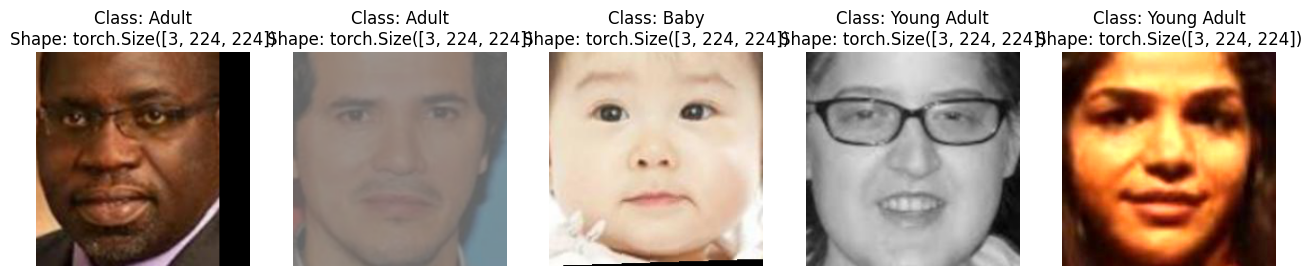

In [35]:
# Display random images from the the Custom Dataset
display_random_images(age_train_dataset, n=5,
                     classes=age_labels, seed=None)

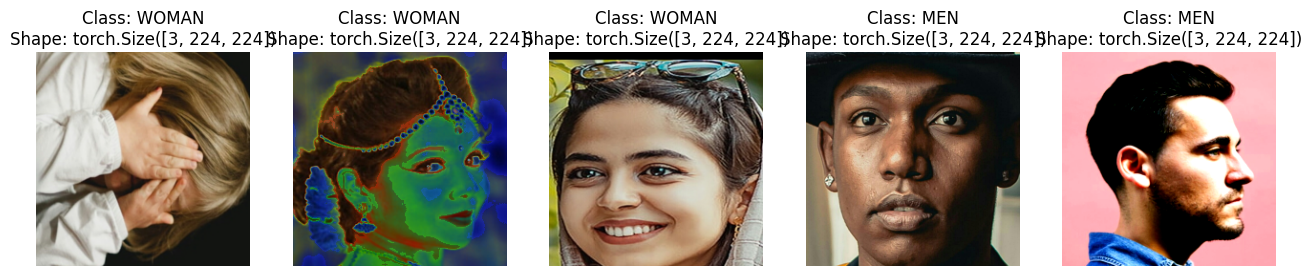

In [36]:
# Display random images from the the Custom Dataset
display_random_images(gender_train_dataset, n=5,
                     classes=gender_labels, seed=None)

### 4.2 Create Emotion Dataset using ImageFolder

In [37]:
# Turn image folders into Datasets
from torchvision import datasets

emotion_train_dataset = datasets.ImageFolder(root=train_emotion_dir,
                                            transform=train_transforms_trivial)

emotion_test_dataset = datasets.ImageFolder(root=test_emotion_dir,
                                        transform=test_transforms)

In [38]:
len(emotion_train_dataset), len(emotion_test_dataset)

(28821, 7066)

In [39]:
emotion_train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [40]:
type(emotion_test_dataset)

torchvision.datasets.folder.ImageFolder

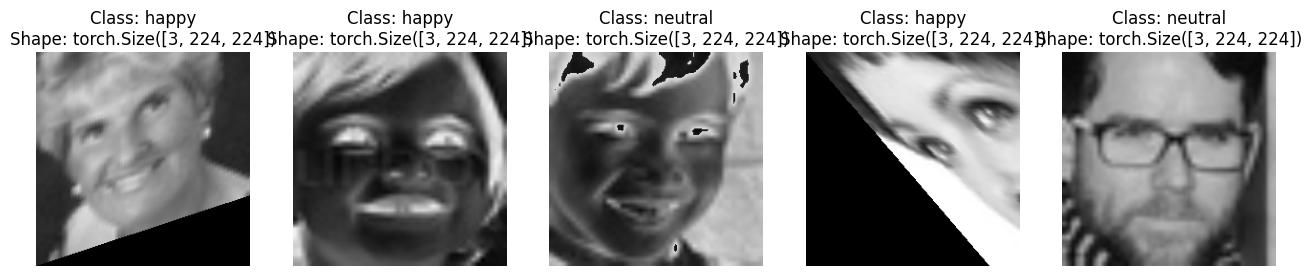

In [41]:
# Display random images from the the Custom Dataset
display_random_images(emotion_train_dataset, n=5,
                     classes=emotion_train_dataset.classes, seed=None)

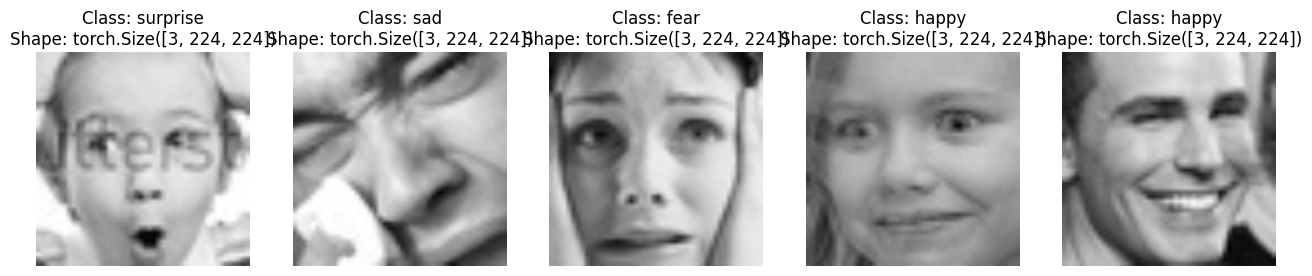

In [42]:
# Display random images from the the Custom Dataset
display_random_images(emotion_test_dataset, n=5,
                     classes=emotion_train_dataset.classes, seed=None)

## 5. Turn all Dataset into DataLoader

In [43]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

# Age Dataset
age_train_dataloader = DataLoader(dataset=age_train_dataset, 
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

age_test_dataloader = DataLoader(dataset=age_test_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

# Gender Dataset
gender_train_dataloader = DataLoader(dataset=gender_train_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      num_workers=NUM_WORKERS)

gender_test_dataloader = DataLoader(dataset=gender_test_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False, 
                                      num_workers=NUM_WORKERS)

# Emotion Dataset
emotion_train_dataloader = DataLoader(dataset=emotion_train_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      num_workers=NUM_WORKERS)

emotion_test_dataloader = DataLoader(dataset=emotion_test_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False, 
                                      num_workers=NUM_WORKERS)

In [44]:
emotion_train_dataloader.batch_size

64

## Model Architecture 

In [45]:
import torch
import torch.nn as nn
from torchvision import models

class MultiTaskEfficientNetB0(nn.Module):
    def __init__(self, num_age_bins, num_emotions):
        super(MultiTaskEfficientNetB0, self).__init__()

        # Shared Backbone
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.backbone.classifier = nn.Identity()

        # Age Head
        self.age_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_age_bins),
            nn.Softmax(dim=1)
        )

        # Gender Head
        self.gender_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        # Emotion Head
        self.emotion_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_emotions),  # Number of emotions
            nn.Softmax(dim=1)  # Multi-class output
        )
    
    def forward(self, x):
        # Shared features
        features = self.backbone(x)
        
        # Task-specific outputs
        age_output = self.age_head(features)
        gender_output = self.gender_head(features)
        emotion_output = self.emotion_head(features)
        
        return age_output, gender_output, emotion_output 

In [46]:
emotion_idx = emotion_train_dataset.class_to_idx
emotion_idx, age_idx

({'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6},
 {'Baby': 0,
  'Child': 1,
  'Teen': 2,
  'Young Adult': 3,
  'Adult': 4,
  'Elderly': 5})

In [47]:
NUM_AGE_BINS = len(age_idx)
NUM_EMOTIONS = len(emotion_train_dataset.class_to_idx)

multitask_model = MultiTaskEfficientNetB0(num_age_bins=NUM_AGE_BINS, num_emotions=NUM_EMOTIONS).to(device)
print(multitask_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


MultiTaskEfficientNetB0(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
         

In [48]:
from torchsummary import summary

# Assuming input size is (3, 224, 224) for RGB images
summary(multitask_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1